In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import PIL
from PIL import Image
import random
import os



In [2]:
random.seed(0)
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])


,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


Main Data Shape: (9896, 6)
Extra Data Shape: (10384, 4)
Common Columns: 
      InstanceID
      patientID
      ImageName
      isCancerous
Unique Main Columns: 
      cellType
      cellTypeName
Null Main Data: InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
Duplicated Main Data: 0
Images Duplicated:  0
Value counts for Iscancerous
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Percent size: 
0: 58.78132578819725
1: 41.21867421180275


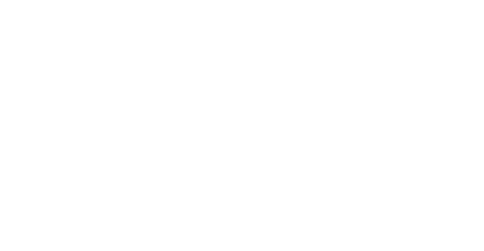

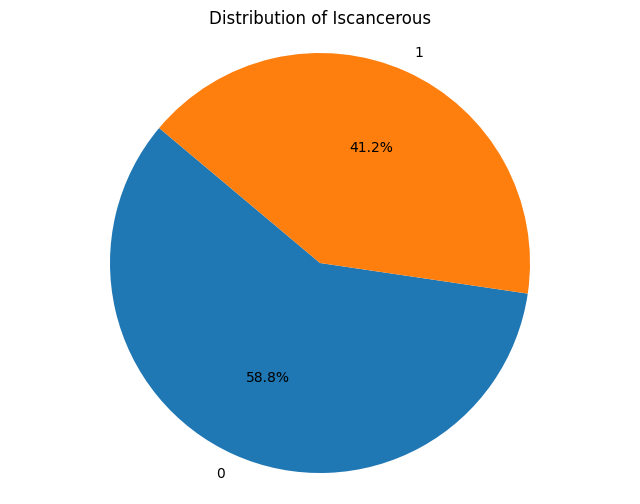

Value counts for Celltypename
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Percent size: 
Epithelial: 41.21867421180275
Inflammatory: 25.697251414713012
Fibroblast: 19.078415521422798
Others: 14.005658852061439


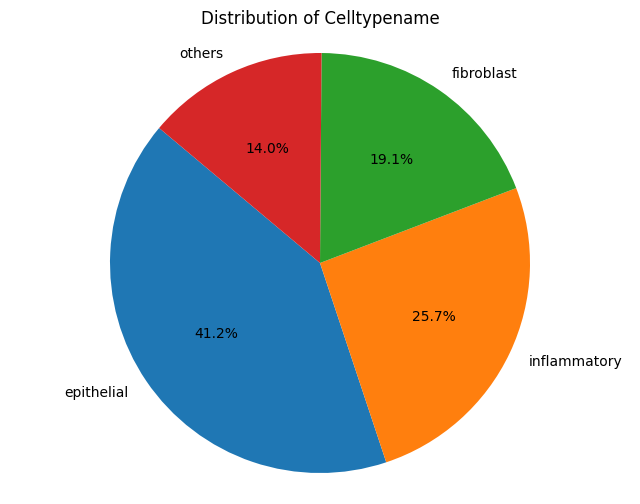

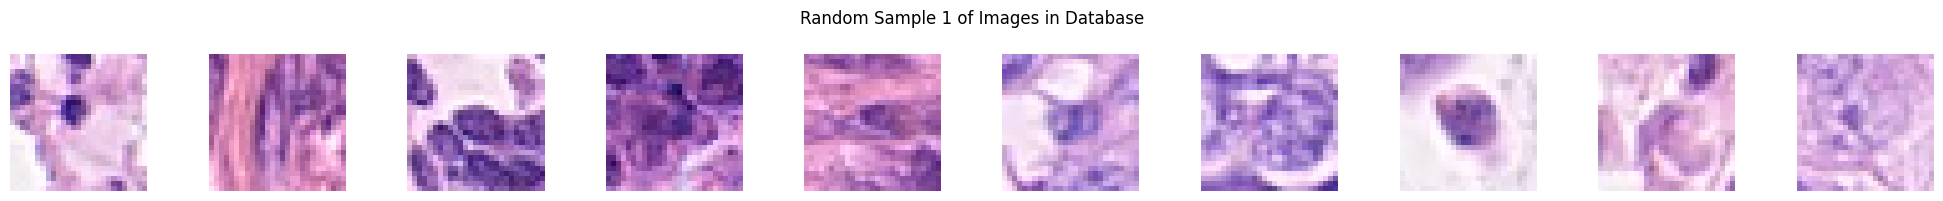

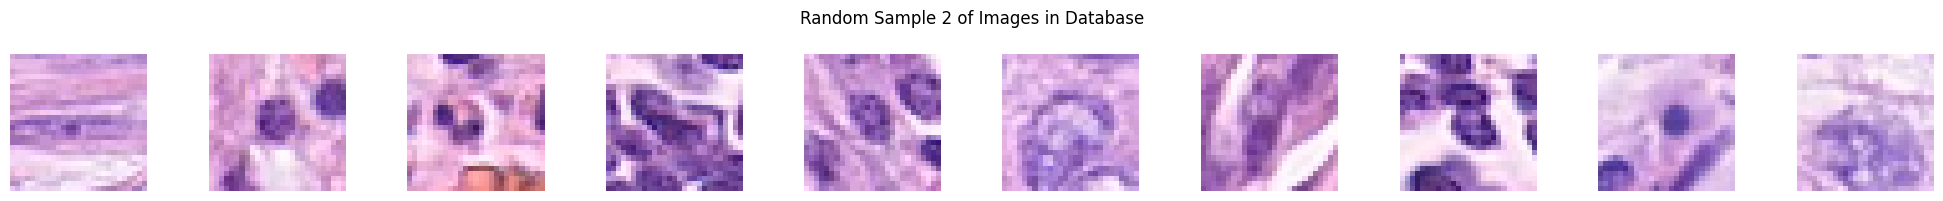

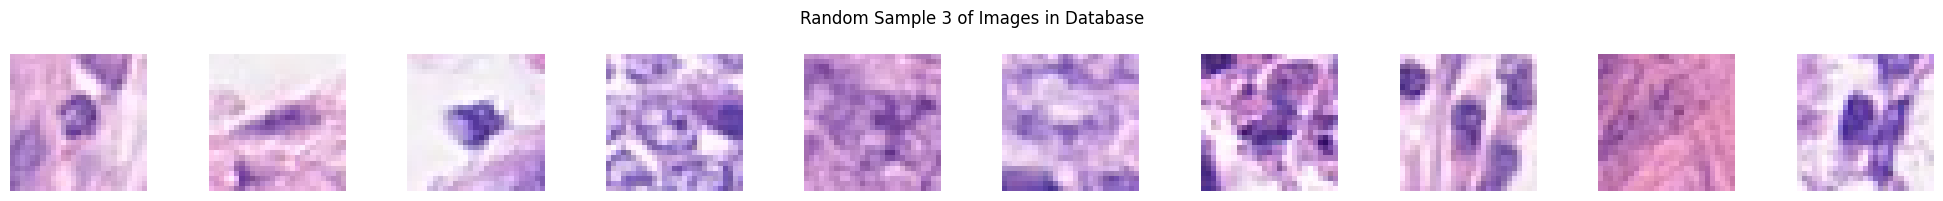

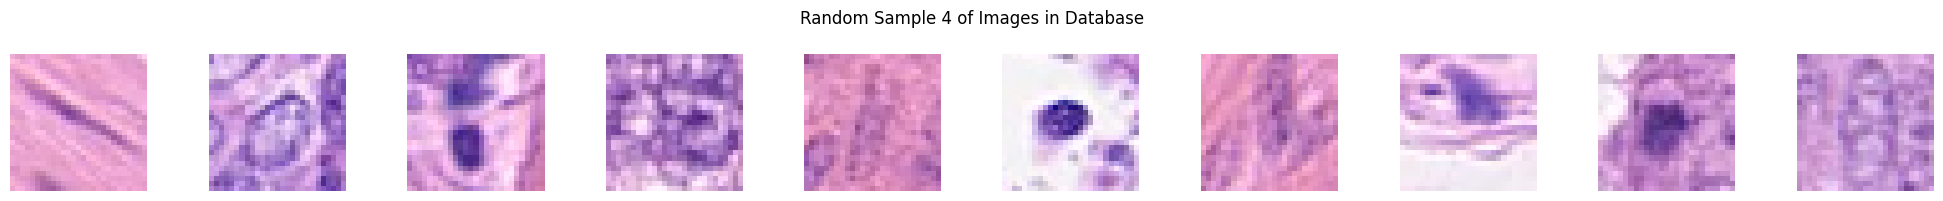

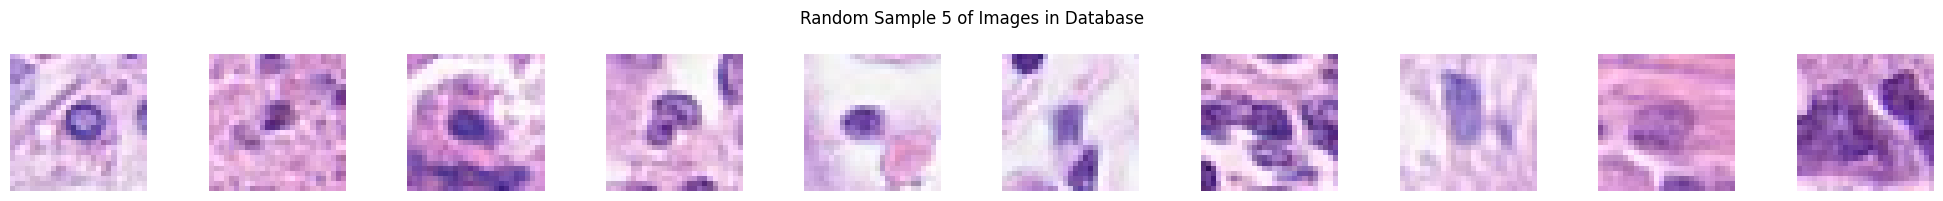

In [3]:
#EDA
fig, ax = plt.subplots(figsize=(6,3))
ax.axis("off")

#Structure and Size
print("Main Data Shape: " + str(data_main.shape))
print("Extra Data Shape: " + str(data_extra.shape))
print("Common Columns: ")

for column in data_main.columns.intersection(data_extra.columns):
    print("      "+ column)
print("Unique Main Columns: ")
for column in data_main.columns.symmetric_difference(data_extra.columns):
    print("      "+ column)

print("Null Main Data: " + str(data_main.isnull().sum()))
print("Duplicated Main Data: " + str(data_main.duplicated().sum()))
print("Images Duplicated:  " + str(data_main["ImageName"].duplicated().sum()))

#Value Counts
relevantColumns = ["isCancerous", "cellTypeName"]
for col in relevantColumns:
    print(f"Value counts for " + col.capitalize())
    value_counts = data_main[col].value_counts()
    print(value_counts)
    print("Percent size: " )
    
    for value, amount in data_main[col].value_counts().items():
        print(str(value).capitalize() + ": " + str((amount/len(data_main[col]))*100))
    
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.axis('equal')  
    plt.show()

pd.crosstab(data_main["cellTypeName"], data_main["isCancerous"])

#Random Sampling
dir = "./patch_images/" 
for i in range(1, 6):
    fig, axes = plt.subplots(1, 10, figsize=(20,2))
    fig.suptitle("Random Sample " + str(i) + " of Images in Database")
    sampledRows = data_main.sample(10)
    for j, ax in enumerate(axes):
        image_name = sampledRows.iloc[j]["ImageName"]
        img = np.asarray(Image.open(dir + image_name))
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [5]:

def AugmentData(imageNames ,maxCount, originalDF, label, labelName):
    
    counter = len(imageNames)

    augmentedRows = []
    
    dir = "./patch_images/"
    augDir = dir + "augmented_images/" + labelName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    existing_aug_count = len(existing_aug)
    counter += existing_aug_count
    print("Number of Files Detected: " + str(counter) + "Max Count: " + str(maxCount))
    if(counter >= maxCount):
        return

    # #Empty the directory
    # for fileName in os.listdir(augDir):
    #     file_path = os.path.join(augDir, fileName)
    #     if(os.path.isfile(file_path)):
    #         os.remove(file_path)

    
    while counter < maxCount:
        counter += 1
        #Pick and random image and open
        chosenImage = imageNames[random.randint(0, len(imageNames)-1)]
        openedImage = PIL.Image.open(dir + chosenImage).convert("RGB")
       
        #convert to data 
        image_np = np.array(openedImage)
        image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, 0)  # Add batch dimension
        
        data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        ])
        augmented_tensor = data_augmentation(image_tensor)
        augmented_image = tf.cast(tf.squeeze(augmented_tensor), tf.uint8).numpy()
        augmented_pil = PIL.Image.fromarray(augmented_image)

        augmentedImageName = "Augmented" + str(counter) +".png"
        save_path = os.path.join(augDir + augmentedImageName)
        augmented_pil.save(save_path)
        new_row = {"ImageName": augmentedImageName, "cellType": label, "cellTypeName": labelName}
        augmentedRows.append(new_row)
    
    return pd.DataFrame(augmentedRows)

In [4]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

IMG_SIZE = 27
cell_type_counts = data_main["cellType"].value_counts().sort_index()
most_common_cell_type = cell_type_counts.idxmax()
print(most_common_cell_type)
max_value = cell_type_counts.max()
print(max_value)

cell_type_mapping = data_main.drop_duplicates(subset=["cellType"])[["cellType", "cellTypeName"]].sort_values("cellType")
cell_type_names = cell_type_mapping["cellTypeName"].values
cell_type_dict = dict(zip(cell_type_mapping["cellType"], cell_type_mapping["cellTypeName"]))
print(cell_type_dict)


cellType0Images = data_main[data_main["cellType"] == 0]["ImageName"].values
cellType1Images = data_main[data_main["cellType"] == 1]["ImageName"].values
cellType2Images = data_main[data_main["cellType"] == 2]["ImageName"].values
cellType3Images = data_main[data_main["cellType"] == 3]["ImageName"].values

imageCollections = []
imageCollections.append(cellType0Images)
imageCollections.append(cellType1Images)
imageCollections.append(cellType2Images)
imageCollections.append(cellType3Images)

data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
data_type_with_augmentation = data_type.copy()
cell_types_to_generate = cell_type_dict.copy()
del cell_types_to_generate[most_common_cell_type]
print(cell_types_to_generate)
dir = "./patch_images/"
for i, cellType in enumerate(cell_types_to_generate):
    cellTypeName = cell_type_dict[cellType]
    augDir = dir + "augmented_images/" + cellTypeName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    print(len(existing_aug) + len(imageCollections[i]))
    print(max_value)
    if not len(existing_aug) + len(imageCollections[i]) >= max_value:
        augmented_df = AugmentData(imageCollections[i], max_value, data_type, i, cell_type_dict[i])
        data_type_with_augmentation = pd.concat([data_type_with_augmentation, augmented_df], ignore_index=True)


2
4079
{0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}
{0: 'fibroblast', 1: 'inflammatory', 3: 'others'}
4079
4079
4079
4079
6772
4079


In [6]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [7]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='min', restore_best_weights=True)

In [9]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [11]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


**MLP**

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

In [13]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [14]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/50


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - categorical_accuracy: 0.6729 - loss: 0.5971 - val_categorical_accuracy: 0.7756 - val_loss: 0.4797
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.7894 - loss: 0.4738 - val_categorical_accuracy: 0.7628 - val_loss: 0.4505
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8166 - loss: 0.4176 - val_categorical_accuracy: 0.8499 - val_loss: 0.3752
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.8290 - loss: 0.3885 - val_categorical_accuracy: 0.8437 - val_loss: 0.3625
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8299 - loss: 0.3697 - val_categorical_accuracy: 0.8146 - val_loss: 0.4117
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8350 - loss: 0.3704 - val_categorical_accuracy: 0.8341 - val_loss: 0.3711
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8424 - loss: 0.3607

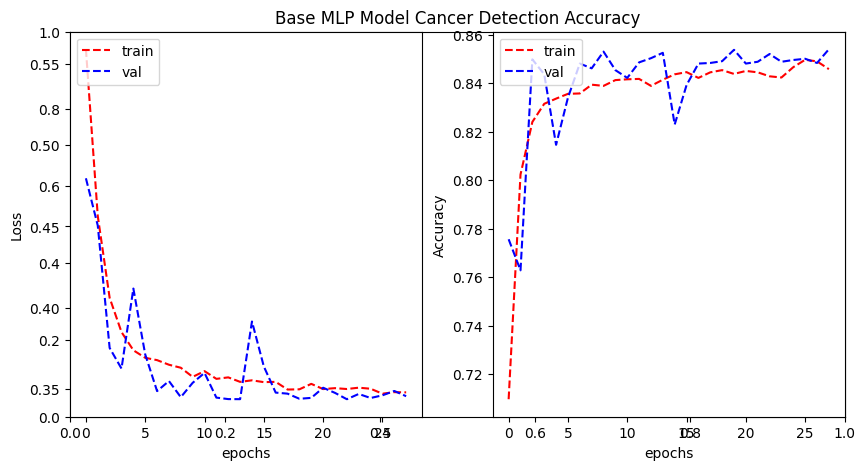

In [15]:
plot_learning_curve("Base MLP Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [16]:
model.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 974us/step - categorical_accuracy: 0.8470 - loss: 0.3403


[0.3455974757671356, 0.848372757434845]

To begin with we created a baseline MLP model very similar to the one used in the workshop in class. It uses a single hidden layer of 256 neurons and a sigmoid activation function with the output layer having 2 neurons (one for each class) and no activation function. The results are decent with 34% loss and 84% accuracy but this can definitely be improved, especially considering the model already converged and begun plateuing by epoch 13

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [18]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [19]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.6788 - loss: 0.6289 - val_categorical_accuracy: 0.8499 - val_loss: 0.3867
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.7917 - loss: 0.4412 - val_categorical_accuracy: 0.8269 - val_loss: 0.3819
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8241 - loss: 0.3876 - val_categorical_accuracy: 0.8358 - val_loss: 0.3687
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8288 - loss: 0.3810 - val_categorical_accuracy: 0.8397 - val_loss: 0.3667
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8241 - loss: 0.3852 - val_categorical_accuracy: 0.8385 - val_loss: 0.3581
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.8374 - loss: 0.3631 - val_categorical_accuracy: 0.8454 - val_loss: 0.3599
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - categorical_accuracy: 0.835

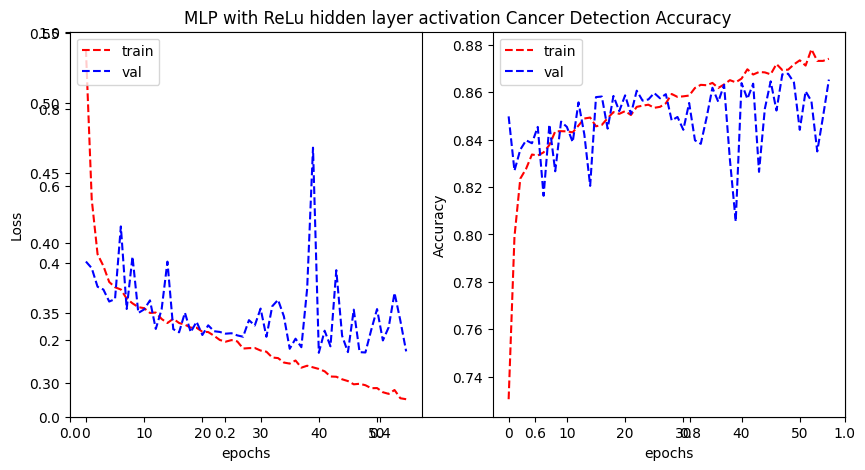

In [20]:
plot_learning_curve("MLP with ReLu hidden layer activation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [21]:
model.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 881us/step - categorical_accuracy: 0.8735 - loss: 0.3016


[0.31625860929489136, 0.8663707971572876]

This model is definitely improved but there is a lot more varience between epochs which leads to a much less smooth graph, however the trend is still clear enough to show the model improving over more epochs reaching around 31% loss and 86% accuracy. Instead of using only an activation for the hidden layers we can have an activation for the output layer and use a single neuron with either isCancerous or not being determined by whether that neuron has been activated or not. We also can change the loss function to be binary crossentropy which allows us to utilise the single output layer neuron instead of needing 2 separate neurons. In order to do this we need to alter the data generators to be binary instead of categorical.

In [22]:

batch_size = 27

train_generator_binary = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator_binary = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [23]:
earlyStopBinary = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, verbose=1, mode='min', restore_best_weights=True)

In [24]:
batch_size = 1

test_generator_binary = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 4056 validated image filenames belonging to 2 classes.


In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [26]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6923 - loss: 0.5998 - val_accuracy: 0.8286 - val_loss: 0.3932
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8019 - loss: 0.4274 - val_accuracy: 0.7991 - val_loss: 0.4283
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8176 - loss: 0.3983 - val_accuracy: 0.8474 - val_loss: 0.3560
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8274 - loss: 0.3845 - val_accuracy: 0.8538 - val_loss: 0.3468
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8329 - loss: 0.3748 - val_accuracy: 0.8540 - val_loss: 0.3456
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8400 - loss: 0.3570 - val_accuracy: 0.8518 - val_loss: 0.3496
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8360 - loss: 0.3607 - val_accuracy: 0.8511 - val_loss: 0.3478
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8362 - loss: 0.3675 - val_accuracy: 0.8489

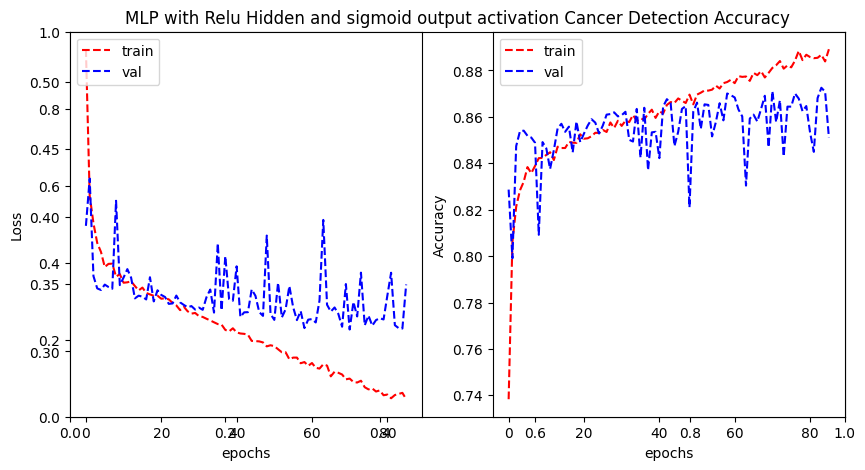

In [28]:
plot_learning_curve("MLP with Relu Hidden and sigmoid output activation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [29]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 3s 855us/step - accuracy: 0.8717 - loss: 0.3085


[0.3053964674472809, 0.8740137815475464]

This model so far is noticably improved but takes longer to train with the initial accuracy and loss being bad and it taking longer to reach similar levels to the previous models, however it does continue to climb further over more epochs leading to around 1-2% more accuracy and less loss

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [31]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [32]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6976 - loss: 0.5699 - val_accuracy: 0.7944 - val_loss: 0.4530
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7913 - loss: 0.4463 - val_accuracy: 0.8018 - val_loss: 0.4267
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8089 - loss: 0.4130 - val_accuracy: 0.8092 - val_loss: 0.4095
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8264 - loss: 0.3857 - val_accuracy: 0.8484 - val_loss: 0.3557
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8378 - loss: 0.3724 - val_accuracy: 0.8274 - val_loss: 0.3795
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8321 - loss: 0.3704 - val_accuracy: 0.8484 - val_loss: 0.3529
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8374 - loss: 0.3645 - val_accuracy: 0.8437 - val_loss: 0.3571
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8448 - loss: 0.3549 - val_

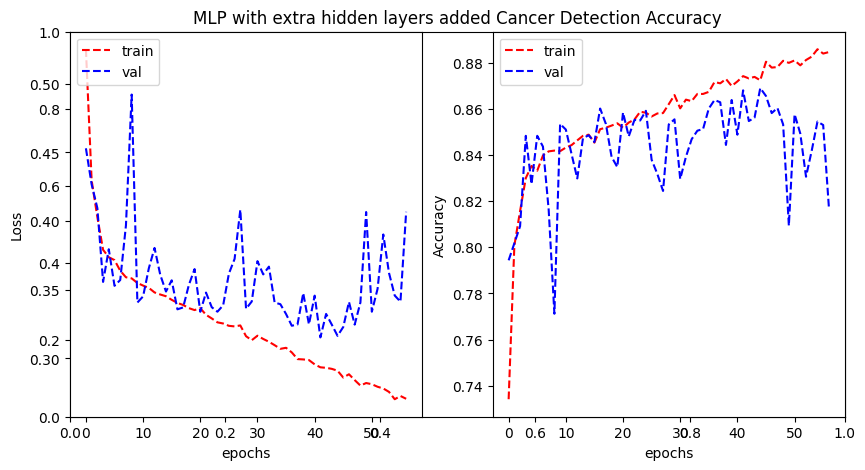

In [33]:
plot_learning_curve("MLP with extra hidden layers added Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [34]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 923us/step - accuracy: 0.8721 - loss: 0.3119


[0.3080088198184967, 0.8725345134735107]

This one had marginal differences in results which is within margin of error however it converged on these values a little quicker which is interesting as the model is more complex

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [36]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [38]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8597 - loss: 0.3142 - val_accuracy: 0.8558 - val_loss: 0.3385
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8642 - loss: 0.3201 - val_accuracy: 0.8459 - val_loss: 0.3548
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8697 - loss: 0.3110 - val_accuracy: 0.8565 - val_loss: 0.3430
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8653 - loss: 0.3101 - val_accuracy: 0.8592 - val_loss: 0.3330
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8586 - loss: 0.3179 - val_accuracy: 0.8642 - val_loss: 0.3278
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8678 - loss: 0.3040 - val_accuracy: 0.8558 - val_loss: 0.3572
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8596 - loss: 0.3155 - val_accuracy: 0.8356 - val_loss: 0.3852
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8671 - loss: 0.3091 - 

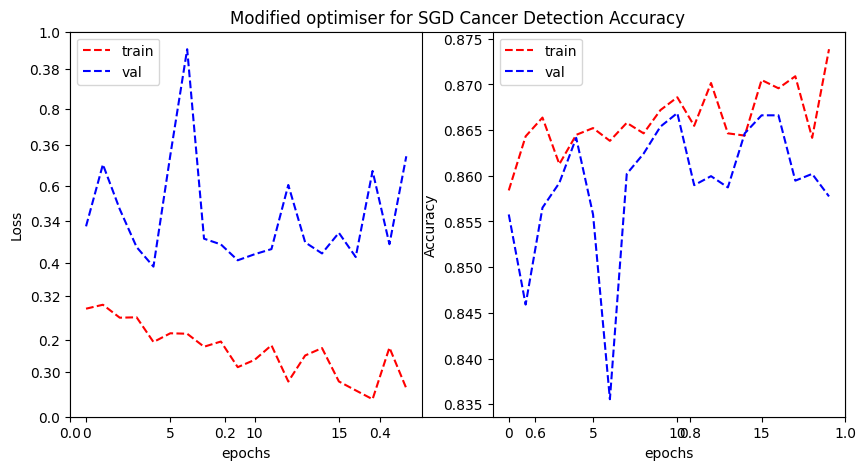

In [ ]:
plot_learning_curve("Modified optimiser for SGD Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [40]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 946us/step - accuracy: 0.8653 - loss: 0.3218


[0.31602734327316284, 0.8661242723464966]

This seems to negatively affect the model so we will not be continuing to use it, we can try using the adam optimiser to see if that helps but we may be nearing the limit of the MLP model

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [42]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6995 - loss: 0.5927 - val_accuracy: 0.8503 - val_loss: 0.3569
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8183 - loss: 0.4020 - val_accuracy: 0.8511 - val_loss: 0.3479
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8318 - loss: 0.3771 - val_accuracy: 0.8484 - val_loss: 0.3536
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8315 - loss: 0.3829 - val_accuracy: 0.8262 - val_loss: 0.3801
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8318 - loss: 0.3769 - val_accuracy: 0.8210 - val_loss: 0.3877
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8372 - loss: 0.3759 - val_accuracy: 0.8538 - val_loss: 0.3455
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8293 - loss: 0.3692 - val_accuracy: 0.8508 - val_loss: 0.3481
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8397 - loss: 0.3604 - 

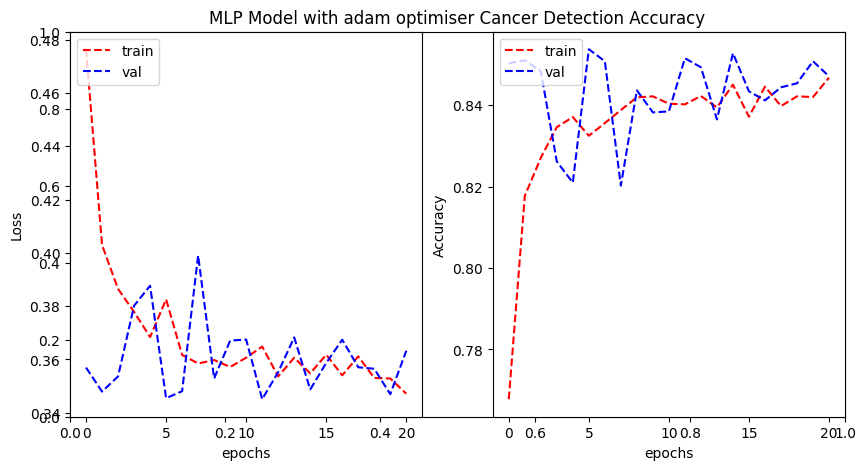

In [44]:
plot_learning_curve("MLP Model with adam optimiser Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [45]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 937us/step - accuracy: 0.8586 - loss: 0.3409


[0.3459257483482361, 0.8523175716400146]

The accuracy and loss for this one was all over the place but the best accuracy was sitting at the same value of 85% but the loss was sigificantly higher than the previous few models so from all this the optimal model was the extra hidden layers but before we started to alter the optimiser which is what we will be going back to for any future modifications. As the current best model had the issue of overfitting we can use regularisation to try to combat this

In [49]:
from tensorflow.keras import regularizers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [50]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator_binary, validation_data = validation_generator_binary, epochs=100, callbacks=earlyStopBinary, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6927 - loss: 1.9145 - val_accuracy: 0.8432 - val_loss: 1.7124
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8016 - loss: 1.7506 - val_accuracy: 0.7347 - val_loss: 1.8334
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8257 - loss: 1.6908 - val_accuracy: 0.6886 - val_loss: 1.9021
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8207 - loss: 1.6629 - val_accuracy: 0.8454 - val_loss: 1.6086
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8315 - loss: 1.6289 - val_accuracy: 0.8543 - val_loss: 1.5743
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8358 - loss: 1.5950 - val_accuracy: 0.8107 - val_loss: 1.6205
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8383 - loss: 1.5658 - val_accuracy: 0.8146 - val_loss: 1.5817
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8374 - loss: 1.5481 - 

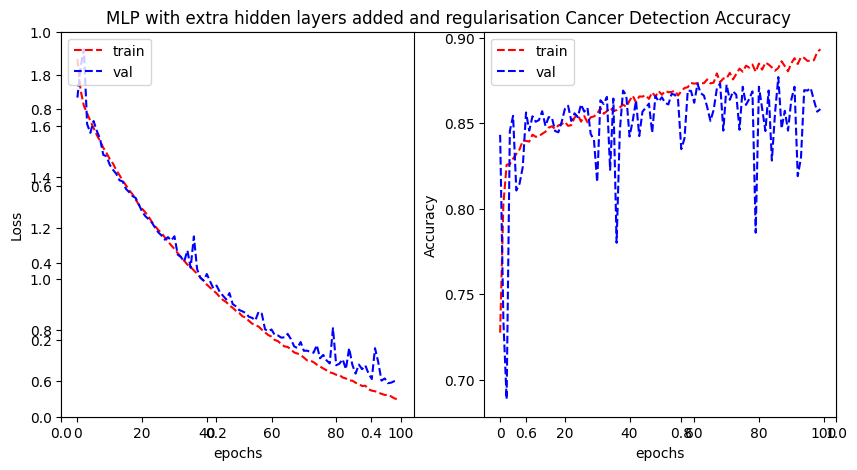

In [54]:
plot_learning_curve("MLP with extra hidden layers added and regularisation Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [53]:
model.evaluate(test_generator_binary)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 4s 986us/step - accuracy: 0.8735 - loss: 0.5758


[0.5855534076690674, 0.8685897588729858]

The loss was dropping for this one and the overfitting was reduced however even after a full 100 epochs it still was not as good as the model without regularisation so it is not worth it even if it will eventually be better because of how much longer it takes to train for not even a guarantee of improvement

It seems like ~87% accuracy with ~30% loss is about as good as the MLP model is going to get for the cancer detection problem which is better than the ~84% accuracy and ~35% loss from the initial model however there just is not very much room for growth without moving to a CNN

**CNN**

In [55]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [57]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - categorical_accuracy: 0.6360 - loss: 0.6741 - val_categorical_accuracy: 0.6573 - val_loss: 0.6484
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.6467 - loss: 0.6558 - val_categorical_accuracy: 0.6573 - val_loss: 0.6396
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.7214 - loss: 0.5427 - val_categorical_accuracy: 0.8410 - val_loss: 0.3695
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.8376 - loss: 0.3754 - val_categorical_accuracy: 0.8282 - val_loss: 0.4005
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8574 - loss: 0.3383 - val_categorical_accuracy: 0.8459 - val_loss: 0.3707
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8729 - loss: 0.3029 - val_categorical_accuracy: 0.8725 - val_loss: 0.3006
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy

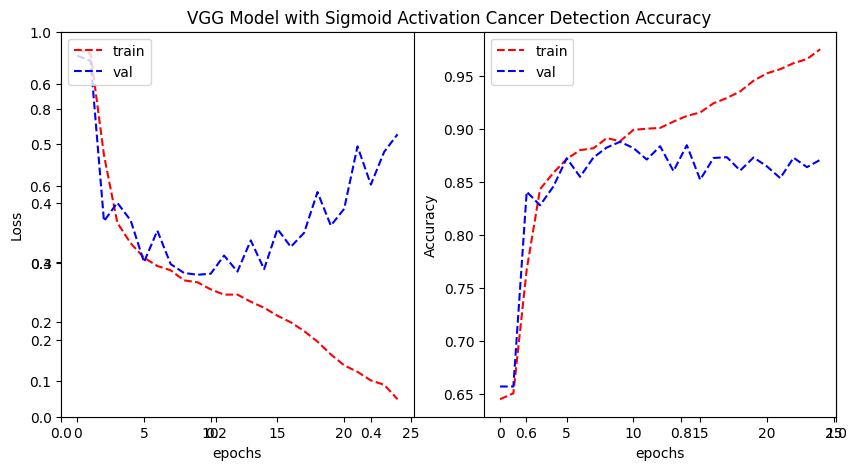

In [58]:
plot_learning_curve("VGG Model with Sigmoid Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_cancerous.evaluate(test_generator)

After doing some research, using sigmoid for the hidden layers can lead to both significant underfitting and overfitting which is exactly what this looks like (sometimes it looks like underfitting sometimes it looks like overfitting)

In [59]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [60]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [61]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - categorical_accuracy: 0.7321 - loss: 0.5178 - val_categorical_accuracy: 0.8600 - val_loss: 0.3306
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8492 - loss: 0.3479 - val_categorical_accuracy: 0.8752 - val_loss: 0.3021
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8724 - loss: 0.3059 - val_categorical_accuracy: 0.8807 - val_loss: 0.2830
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8852 - loss: 0.2901 - val_categorical_accuracy: 0.8834 - val_loss: 0.2837
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8928 - loss: 0.2728 - val_categorical_accuracy: 0.8814 - val_loss: 0.2829
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.8886 - loss: 0.2747 - val_categorical_accuracy: 0.8681 - val_loss: 0.3180
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - categorical_accuracy

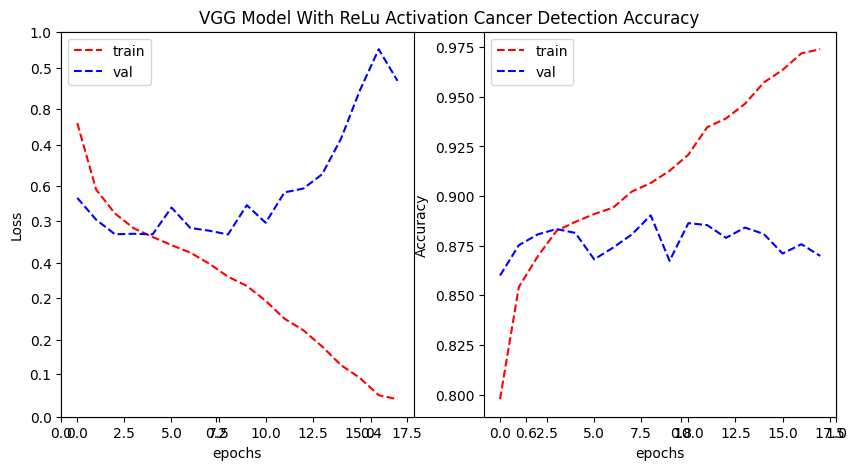

In [62]:
plot_learning_curve("VGG Model With ReLu Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [63]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.8765 - loss: 0.2859


[0.2762773931026459, 0.8841223120689392]

Now it is clearly overfitting consistently so we can start by simplifying the model as the images are relatively simple in comparison to other images neural networks are used to classify

In [64]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [65]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [66]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7607 - loss: 0.4813 - val_categorical_accuracy: 0.8629 - val_loss: 0.3283
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8575 - loss: 0.3382 - val_categorical_accuracy: 0.8767 - val_loss: 0.2969
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8730 - loss: 0.3081 - val_categorical_accuracy: 0.8728 - val_loss: 0.3035
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8745 - loss: 0.2945 - val_categorical_accuracy: 0.8681 - val_loss: 0.3181
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8813 - loss: 0.2819 - val_categorical_accuracy: 0.8777 - val_loss: 0.2851
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8906 - loss: 0.2688 - val_categorical_accuracy: 0.8908 - val_loss: 0.2644
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy

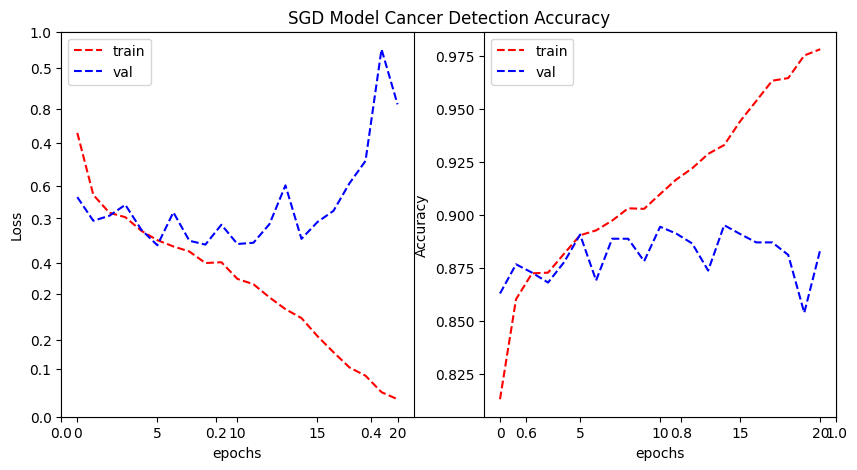

In [67]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [68]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.8999 - loss: 0.2505


[0.2505832612514496, 0.8976824283599854]

The model is still overfitting but less so, now we can try regularisation

In [69]:

model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [70]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [71]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - categorical_accuracy: 0.7307 - loss: 0.6315 - val_categorical_accuracy: 0.8619 - val_loss: 0.3794
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - categorical_accuracy: 0.8509 - loss: 0.3990 - val_categorical_accuracy: 0.8671 - val_loss: 0.3575
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - categorical_accuracy: 0.8543 - loss: 0.3768 - val_categorical_accuracy: 0.8664 - val_loss: 0.3627
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8638 - loss: 0.3680 - val_categorical_accuracy: 0.8531 - val_loss: 0.3716
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8698 - loss: 0.3549 - val_categorical_accuracy: 0.8814 - val_loss: 0.3240
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.8708 - loss: 0.3477 - val_categorical_accuracy: 0.8656 - val_loss: 0.3493
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy

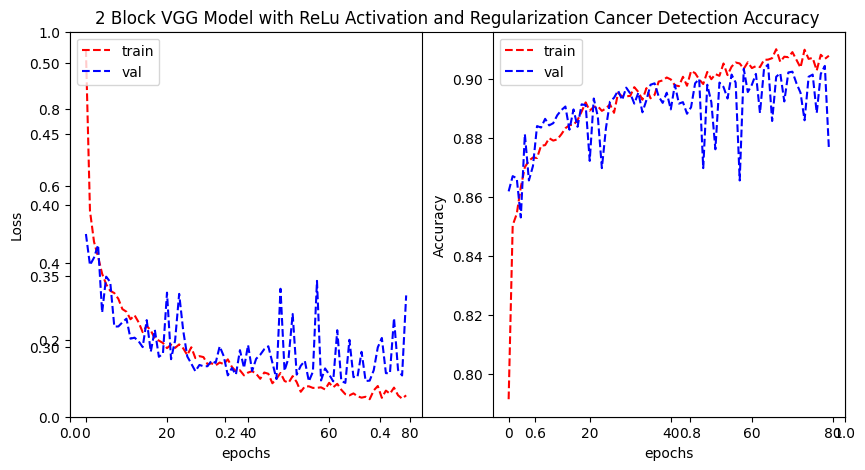

In [72]:
plot_learning_curve("2 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [73]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - categorical_accuracy: 0.9121 - loss: 0.2559


[0.2659702003002167, 0.9055719971656799]

This very clearly has worked so now we can try to add back the other hidden block and see if the model can handle it now or if it still is too complex for the task. Even though there is still overfitting, it is significantly reduced allowing the model to continue to grow much futher

In [74]:

model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [75]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [76]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - categorical_accuracy: 0.6526 - loss: 0.7724 - val_categorical_accuracy: 0.6573 - val_loss: 0.6544
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6519 - loss: 0.6514 - val_categorical_accuracy: 0.6573 - val_loss: 0.6456
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6538 - loss: 0.6493 - val_categorical_accuracy: 0.6573 - val_loss: 0.6450
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6459 - loss: 0.6532 - val_categorical_accuracy: 0.6573 - val_loss: 0.6444
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6485 - loss: 0.6503 - val_categorical_accuracy: 0.6573 - val_loss: 0.6432
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.6494 - loss: 0.6503 - val_categorical_accuracy: 0.6573 - val_loss: 0.6505
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy

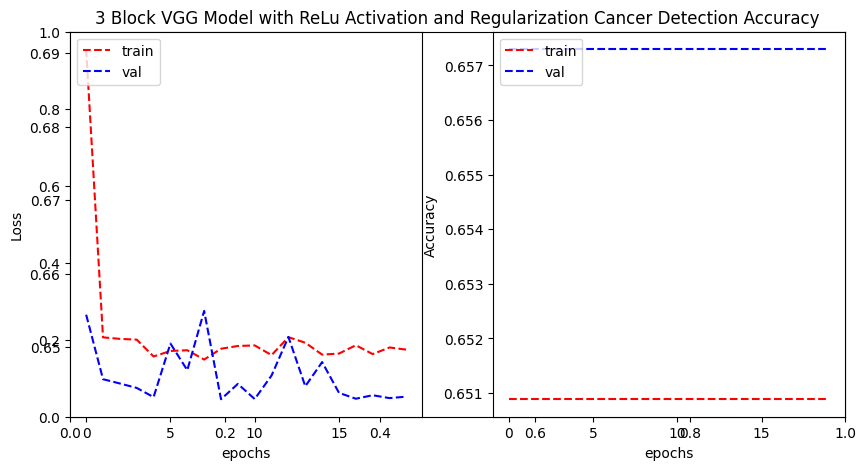

In [77]:
plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [78]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - categorical_accuracy: 0.6444 - loss: 0.6509


[0.649284839630127, 0.6471893787384033]

This very clearly did not work as the model is not fitting at all with the accuracy never changing and the loss being all over the place. The 2 block model seems to be ideal and after all the changes we made the overfitting is not too bad either

Overall CNN was much better with the best models being just over 90% accuracte with a loss of around 25% which is quite good. Even though the models are more complex they do not take that much longer to train than the MLP, the CNN models are quanitfiably more accurate with less loss so there really is no reason not to use them. They also scaled better on more CPU cores than the MLP model which could indicate that they might be faster to train using high core CPUs. Unfortunately GPU support for tensorflow on windows no longer exists with the newer versions of tensorflow so we could not test how they scale on GPUs but if the CPU usage is anything to go by the CNN difference in time between the CNN and the MLP models might become trivial if GPUs were used to train instead of CPUs

**Clasification**

In [79]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
print(data_type)

      InstanceID  patientID  ImageName  cellType
0          22405          1  22405.png         0
1          22406          1  22406.png         0
2          22407          1  22407.png         0
3          22408          1  22408.png         0
4          22409          1  22409.png         0
...          ...        ...        ...       ...
9891        1625         60   1625.png         2
9892        1626         60   1626.png         2
9893        1627         60   1627.png         2
9894        1628         60   1628.png         2
9895        1629         60   1629.png         2

[9896 rows x 4 columns]


In [80]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [81]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [82]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


MLP

In [83]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [84]:
model_classification.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [85]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100


c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.4308 - loss: 1.6903 - val_categorical_accuracy: 0.5629 - val_loss: 1.0699
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.5976 - loss: 1.0074 - val_categorical_accuracy: 0.6134 - val_loss: 0.8948
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.6298 - loss: 0.9017 - val_categorical_accuracy: 0.6205 - val_loss: 0.8891
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.6612 - loss: 0.8740 - val_categorical_accuracy: 0.6670 - val_loss: 0.8334
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.6758 - loss: 0.8273 - val_categorical_accuracy: 0.6478 - val_loss: 0.8404
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6634 - loss: 0.8451 - val_categorical_accuracy: 0.6215 - val_loss: 0.8956
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.6677 - l

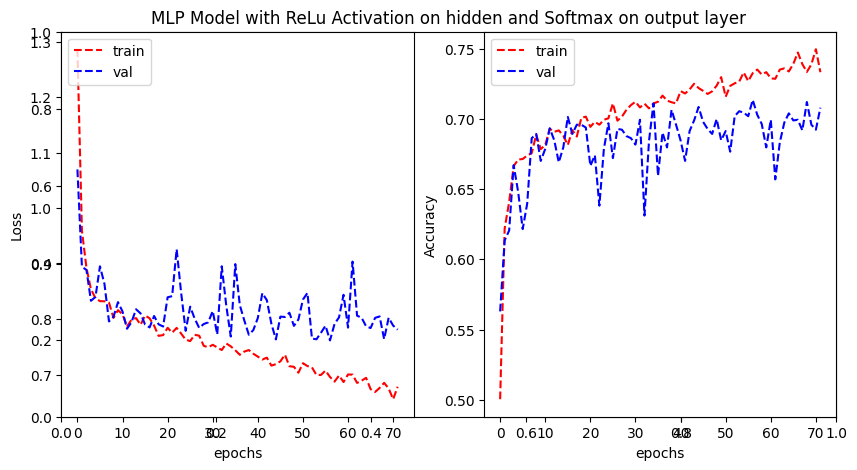

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - categorical_accuracy: 0.6969 - loss: 0.8034


[0.7896362543106079, 0.7030302882194519]

In [86]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

It is a decent start with the model reaching a decent accuracy for a more complex problem however it has quite a high loss which can be improved upon. We can try adding complexity to the model with more layers to try to better fit the more complex classifer

In [87]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [88]:
model_classification.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [89]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.4021 - loss: 1.4225 - val_categorical_accuracy: 0.5538 - val_loss: 1.1003
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.6103 - loss: 0.9765 - val_categorical_accuracy: 0.6680 - val_loss: 0.8488
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6404 - loss: 0.8985 - val_categorical_accuracy: 0.5947 - val_loss: 0.9451
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.6516 - loss: 0.8756 - val_categorical_accuracy: 0.6897 - val_loss: 0.7985
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6619 - loss: 0.8571 - val_categorical_accuracy: 0.7009 - val_loss: 0.7983
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6799 - loss: 0.8024 - val_categorical_accuracy: 0.6943 - val_loss: 0.7998
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy

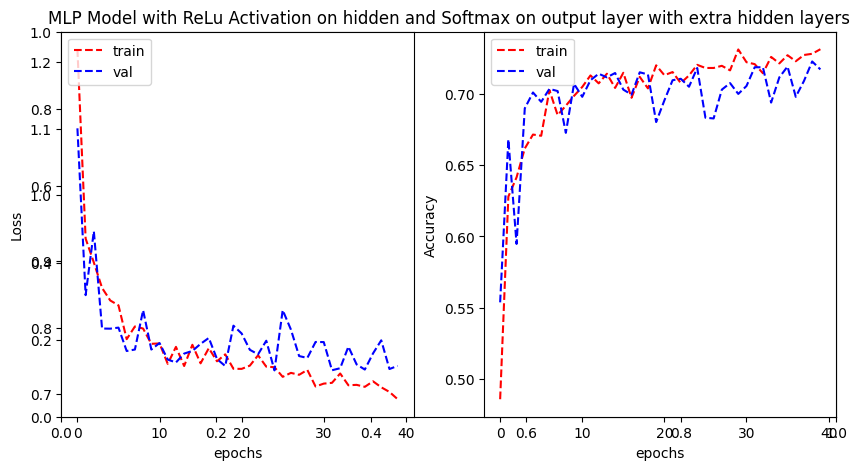

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - categorical_accuracy: 0.7074 - loss: 0.7847


[0.7560026049613953, 0.7151514887809753]

In [90]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer with extra hidden layers", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

The loss is a little improved so we can add even more hidden layers to see if that improves either the loss or the accuracy

In [91]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [92]:
model_classification.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [93]:
history_classification = model_classification.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - categorical_accuracy: 0.4380 - loss: 1.4435 - val_categorical_accuracy: 0.5816 - val_loss: 0.9887
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.6140 - loss: 0.9471 - val_categorical_accuracy: 0.6412 - val_loss: 0.9342
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.6306 - loss: 0.9173 - val_categorical_accuracy: 0.5816 - val_loss: 0.9603
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - categorical_accuracy: 0.6480 - loss: 0.8892 - val_categorical_accuracy: 0.5235 - val_loss: 1.1597
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.6591 - loss: 0.8789 - val_categorical_accuracy: 0.6716 - val_loss: 0.8449
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.6879 - loss: 0.8101 - val_categorical_accuracy: 0.6908 - val_loss: 0.8080
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy

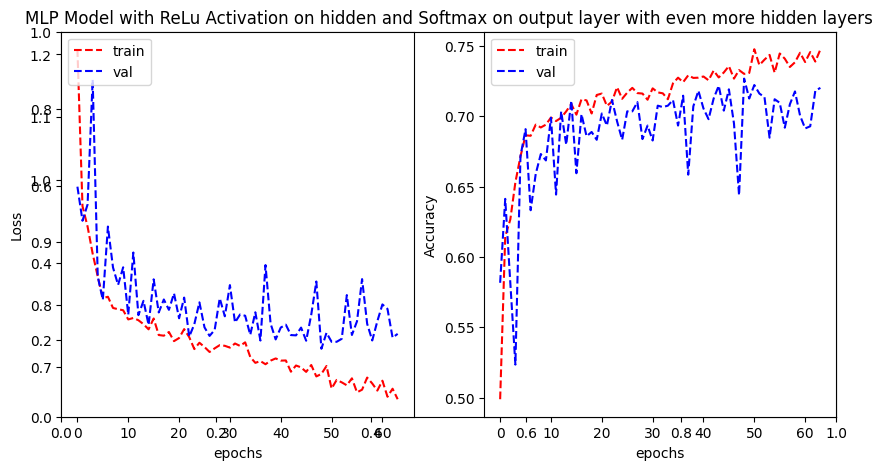

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.6987 - loss: 0.7507


[0.758395791053772, 0.7126262784004211]

In [94]:
plot_learning_curve("MLP Model with ReLu Activation on hidden and Softmax on output layer with even more hidden layers", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator)

The accuracy is similar to the 3 layer NN however the loss is slightly higher and it appears to be overfitting plus it takes longer to train so the extra layer did not help but made the model worse. Here we can use our augmented dataset to try to reduce the overfitting from earlier

In [95]:
train_data_type_augment, test_data_type_augment = train_test_split(data_type_with_augmentation, test_size=0.2, random_state=42)
train_data_type_augment, val_data_type_augment = train_test_split(train_data_type_augment, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [96]:
train_data_type_augment['cellType'] = train_data_type_augment['cellType'].astype('str')
val_data_type_augment['cellType'] = val_data_type_augment['cellType'].astype('str')

train_datagen_augment = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_augment = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_augment = train_datagen_augment.flow_from_dataframe(
        dataframe=train_data_type_augment,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_augment = val_datagen_augment.flow_from_dataframe(
        dataframe=val_data_type_augment,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [97]:
test_data_type_augment['cellType'] = test_data_type_augment['cellType'].astype('str')

test_datagen_augment = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_augment = test_datagen_augment.flow_from_dataframe(
        dataframe=test_data_type_augment,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [ ]:
model_classification = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [ ]:
model_classification.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [ ]:
history_classification = model_classification.fit(train_generator_augment, validation_data = validation_generator_augment, epochs=100, callbacks=earlyStop, verbose=1)

Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.4021 - loss: 1.4225 - val_categorical_accuracy: 0.5538 - val_loss: 1.1003
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.6103 - loss: 0.9765 - val_categorical_accuracy: 0.6680 - val_loss: 0.8488
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6404 - loss: 0.8985 - val_categorical_accuracy: 0.5947 - val_loss: 0.9451
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.6516 - loss: 0.8756 - val_categorical_accuracy: 0.6897 - val_loss: 0.7985
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6619 - loss: 0.8571 - val_categorical_accuracy: 0.7009 - val_loss: 0.7983
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.6799 - loss: 0.8024 - val_categorical_accuracy: 0.6943 - val_loss: 0.7998
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy

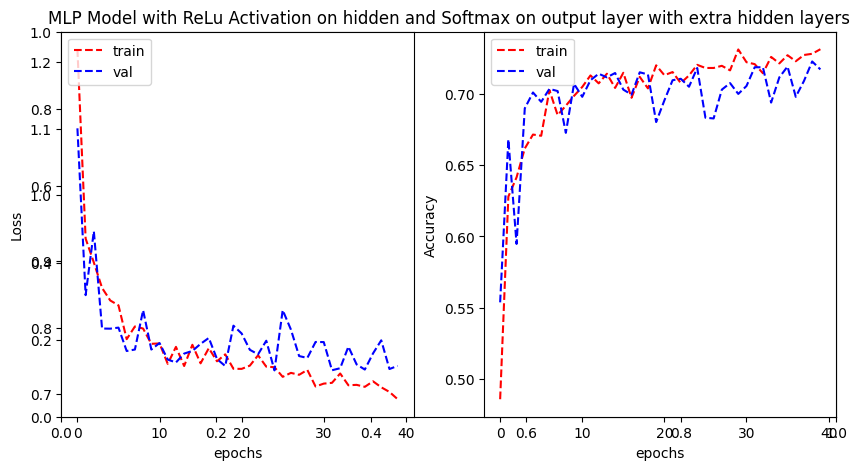

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - categorical_accuracy: 0.7074 - loss: 0.7847


[0.7560026049613953, 0.7151514887809753]

In [ ]:
plot_learning_curve("MLP Model with data augmentation", history_classification.history['loss'], history_classification.history['val_loss'], 
                    history_classification.history['categorical_accuracy'], history_classification.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_classification.evaluate(test_generator_augment)

CNN

In [ ]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

In [ ]:
model_VGG_1_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [ ]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)
history_VGG_1_softmax = model_VGG_1_softmax.fit(train_generator, validation_data = validation_generator, epochs=100, callbacks=earlyStop, verbose=1)

In [ ]:
plot_learning_curve("VGG Model with ReLu Activation (Cell Type Identification)",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)
plot_learning_curve("VGG Model with Sigmoid Activation (Cell Type Identification)",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)

plot_learning_curve("VGG Model with Softmax Activation (Cell Type Identification)",history_VGG_1_softmax.history['loss'], history_VGG_1_softmax.history['val_loss'], 
                    history_VGG_1_softmax.history['categorical_accuracy'], history_VGG_1_softmax.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax.evaluate(test_generator)


This shows a significant amount of overfitting, due to the model learning valuing irrelevant features like noise resulting in worse performance with new data. Softmax is having the same issue of underfitting that using only sigmoid for all hidden layers is having so it is worth testing with relu for hidden and softmax for the final layer

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    # preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.2),
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [ ]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=25, callbacks=earlyStop, verbose=1)

plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization (Cell Type Identification)", history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Significantly better results just with regularization, will try to fit better later

In [ ]:
#Using extra data to  improve the cell type classification
extra_data_for_type = data_extra[["InstanceID", "patientID", "ImageName"]]

def preprocess_image(filename, img_dir="./patch_images/"):
    path = os.path.join(img_dir, filename)
    image = Image.open(path).convert("RGB")
    image = image.resize((27, 27))
    image_array = np.array(image).astype(np.float32) / 255.0
    return image_array

X_extra = np.array([
    preprocess_image(name) for name in extra_data_for_type["ImageName"]
])

predictions = model_VGG_2.predict(X_extra)
predicted_classes = np.argmax(predictions, axis=1)

label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
predicted_labels = [label_dict[i] for i in predicted_classes]

extra_data_for_type["predicted_cellType"] = predicted_labels

extra_data_for_type.to_csv("extra_data_with_predictions.csv", index=False)

In [ ]:
extra_data_with_predictions = pd.read_csv("extra_data_with_predictions.csv")
extra_data_with_predictions["isCancerous"] = data_extra["isCancerous"]
print(extra_data_with_predictions)
print(data_main)
label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
reverse_dict = {v: k for k, v in label_dict.items()}
newData = pd.concat([data_main, extra_data_with_predictions])
newData["cellTypeName" ] = newData["cellTypeName"].fillna(newData["predicted_cellType"])
newData["cellType"] = newData["cellType"].fillna(newData["cellTypeName"].map(reverse_dict))
newData = newData.drop(columns=["predicted_cellType"])
#Just need to plug this into the cancerous model and compare results
print(newData) 
